<a href="https://colab.research.google.com/github/Lee-Minsoo-97/Yelp_Review_Analysis/blob/main/ChipotleVSTacobell_Yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First Cell: All Imports
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
!pip install vaderSentiment
!pip install vaderSentiment textblob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Ensure spaCy large model is installed
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    print("Downloading 'en_core_web_lg' model...")
    import os
    os.system("python -m spacy download en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")

# Ensure required NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##1. Data Preprocessing

In [ ]:
# 1.1 Load Dataset
path = "/content/drive/MyDrive/Colab Notebooks/Unstructed data/Project/combined_r.csv"
df = pd.read_csv(path)

In [ ]:
# Keep only necessary columns
df = df[['stars', 'text', 'name']]

# Drop missing values
df.dropna(subset=['text', 'stars', 'name'], inplace=True)

# 1.2 Text Cleaning
# Convert text to lowercase
df['text'] = df['text'].astype(str).str.lower()

# Remove URLs and extra spaces
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = text.strip()  # Remove leading/trailing spaces
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

<ipython-input-6-01d77c39f681>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['text', 'stars', 'name'], inplace=True)
<ipython-input-6-01d77c39f681>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str).str.lower()
<ipython-input-6-01d77c39f681>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [ ]:
# 1.3 Tokenization & Stopword Removal
# Tokenization using spaCy
def tokenize_and_remove_stopwords(text):
    doc = nlp(text)
    stop_words = set(stopwords.words('english'))
    return [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]

df['tokens'] = df['cleaned_text'].apply(lambda x: tokenize_and_remove_stopwords(x) if isinstance(x, str) else [])

# 1.4 Convert token list back into cleaned text
df['final_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Display the processed dataset
df.head()

,stars,text,name,cleaned_text,tokens,final_text
0,1,"literally, the worst taco bell i have ever bee...",Taco Bell,"literally, the worst taco bell i have ever bee...","[literally, bad, taco, bell, ever, restaurant,...",literally bad taco bell ever restaurant filthy...
1,3,can't go wrong with some todd cobell!,Taco Bell,can't go wrong with some todd cobell!,"[can, not, go, wrong, todd, cobell]",can not go wrong todd cobell
2,1,went to this taco bell last night. it was 1 3...,Taco Bell,went to this taco bell last night. it was 1 3...,"[go, taco, bell, last, night, , 1, 30, say, 3...",go taco bell last night 1 30 say 30 minute c...
3,3,"if you want to get in and out quick, this kfc/...",Taco Bell,"if you want to get in and out quick, this kfc/...","[want, get, quick, kfc, taco, bell, ok, fast, ...",want get quick kfc taco bell ok fast food plac...
4,3,no complaints as far as taco bells go. terribl...,Taco Bell,no complaints as far as taco bells go. terribl...,"[complaint, far, taco, bell, go, terrible, ter...",complaint far taco bell go terrible terribly d...


##2. Aspect-Based Classification

In [ ]:
# 2.1 Define Aspect Keywords
aspect_keywords = {
    "Food": ["delicious", "tasty", "spicy", "bland", "portion", "flavor", "soggy", "greasy", "stale", "fresh"],
    "Service": ["slow", "friendly", "rude", "wait", "attitude", "staff", "manager", "polite", "ignored", "service"],
    "Price": ["expensive", "cheap", "affordable", "overpriced", "worth", "money", "value"],
    "Cleanliness": ["dirty", "clean", "hygienic", "disgusting", "sanitary", "smell", "stains"]
}

In [ ]:
# 2.2 Classify Aspects Based on Keywords
def classify_aspect(text):
    text_lower = text.lower()
    aspect_counts = {aspect: sum(word in text_lower for word in keywords) for aspect, keywords in aspect_keywords.items()}

    # Assign the aspect with the most keyword matches
    max_aspect = max(aspect_counts, key=aspect_counts.get)

    # If no keywords match, assign 'General' instead of dropping
    return max_aspect if aspect_counts[max_aspect] > 0 else "General"

df["aspect"] = df["final_text"].apply(classify_aspect)

# 2.3 Store Aspect Labels in Memory (No CSV Saving)
print(df[["final_text", "aspect"]].head())

                                          final_text   aspect
0  literally bad taco bell ever restaurant filthy...  Service
1                       can not go wrong todd cobell  General
2  go taco bell last night   1 30 say 30 minute c...  Service
3  want get quick kfc taco bell ok fast food plac...    Price
4  complaint far taco bell go terrible terribly d...  Service


In [ ]:
df.head()

,stars,text,name,cleaned_text,tokens,final_text,aspect
0,1,"literally, the worst taco bell i have ever bee...",Taco Bell,"literally, the worst taco bell i have ever bee...","[literally, bad, taco, bell, ever, restaurant,...",literally bad taco bell ever restaurant filthy...,Service
1,3,can't go wrong with some todd cobell!,Taco Bell,can't go wrong with some todd cobell!,"[can, not, go, wrong, todd, cobell]",can not go wrong todd cobell,General
2,1,went to this taco bell last night. it was 1 3...,Taco Bell,went to this taco bell last night. it was 1 3...,"[go, taco, bell, last, night, , 1, 30, say, 3...",go taco bell last night 1 30 say 30 minute c...,Service
3,3,"if you want to get in and out quick, this kfc/...",Taco Bell,"if you want to get in and out quick, this kfc/...","[want, get, quick, kfc, taco, bell, ok, fast, ...",want get quick kfc taco bell ok fast food plac...,Price
4,3,no complaints as far as taco bells go. terribl...,Taco Bell,no complaints as far as taco bells go. terribl...,"[complaint, far, taco, bell, go, terrible, ter...",complaint far taco bell go terrible terribly d...,Service


##3. Sentiment Analysis

In [ ]:
# 3.1 Auto-Label Sentiment Using VADER/TextBlob

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    vs = analyzer.polarity_scores(text)

    if vs["compound"] >= 0.05:
        return "Positive"
    elif vs["compound"] <= -0.05:
        return "Negative"
    else:
        # If VADER is neutral, use TextBlob as fallback
        blob_sentiment = TextBlob(text).sentiment.polarity
        if blob_sentiment > 0:
            return "Positive"
        elif blob_sentiment < 0:
            return "Negative"
        else:
            return "Neutral"

# Apply sentiment classification
df["sentiment"] = df["final_text"].apply(get_sentiment)

In [ ]:
# 3.2 Convert Sentiment Labels to Numerical Values
sentiment_labels = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["sentiment_label"] = df["sentiment"].map(sentiment_labels)

# Store Sentiment Labels in Memory (No CSV Saving)
print(df[["final_text", "aspect", "sentiment"]].head())


                                          final_text   aspect sentiment
0  literally bad taco bell ever restaurant filthy...  Service  Negative
1                       can not go wrong todd cobell  General  Positive
2  go taco bell last night   1 30 say 30 minute c...  Service  Positive
3  want get quick kfc taco bell ok fast food plac...    Price  Positive
4  complaint far taco bell go terrible terribly d...  Service  Negative


In [ ]:
# prompt: code to check missing values in data

import matplotlib.pyplot as plt
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Check for missing values in the entire DataFrame
total_missing = df.isnull().sum().sum()
print("\nTotal missing values:", total_missing)


Missing values per column:
 stars              0
text               0
name               0
cleaned_text       0
tokens             0
final_text         0
aspect             0
sentiment          0
sentiment_label    0
dtype: int64

Total missing values: 0


In [ ]:
# 3.3 Fine-Tune BERT for Sentiment Classification
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom PyTorch Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.texts = list(df["final_text"])
        self.labels = list(df["sentiment_label"])

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create PyTorch datasets
train_dataset = SentimentDataset(train_df)
val_dataset = SentimentDataset(val_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained BERT model with classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Training Parameters
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Train the Model
from tqdm import tqdm

epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_loss:.4f}")


100%|██████████| 461/461 [02:29<00:00,  3.08it/s]


Epoch 1/4 - Training Loss: 0.3686


100%|██████████| 461/461 [02:28<00:00,  3.10it/s]


Epoch 2/4 - Training Loss: 0.1674


100%|██████████| 461/461 [02:28<00:00,  3.10it/s]


Epoch 3/4 - Training Loss: 0.0909


100%|██████████| 461/461 [02:28<00:00,  3.10it/s]

Epoch 4/4 - Training Loss: 0.0595


##4. Sentiment Analysis Comparison

In [ ]:
# 4.1 Count Sentiment Distribution Per Restaurant
sentiment_counts = df.groupby(["name", "sentiment"]).size().unstack()

# Display Sentiment Counts
print(sentiment_counts)

sentiment  Negative  Neutral  Positive
name                                  
Chipotle       3485       46      6240
Taco Bell      3929       92      4615


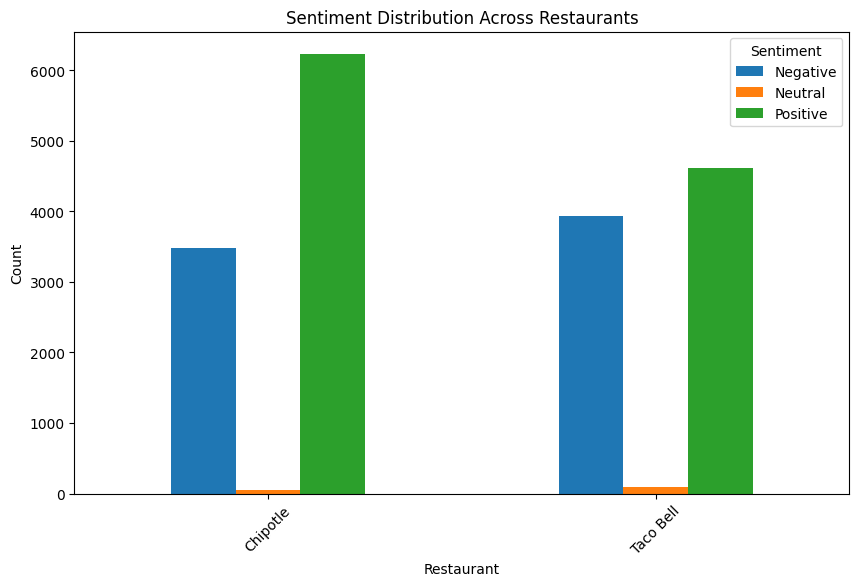

In [ ]:
# 4.2 Visualizing Sentiment Trends

# Plot sentiment distribution
sentiment_counts.plot(kind='bar', figsize=(10, 6))
plt.title("Sentiment Distribution Across Restaurants")
plt.xlabel("Restaurant")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.show()

sentiment              Negative  Neutral  Positive
name      aspect                                  
Chipotle  Cleanliness     203.0      NaN     220.0
          Food            490.0      5.0    1800.0
          General         877.0     32.0    1316.0
          Price           107.0      NaN     203.0
          Service        1808.0      9.0    2701.0
Taco Bell Cleanliness     138.0      1.0     148.0
          Food            189.0      1.0     515.0
          General        1180.0     63.0    1226.0
          Price           132.0      3.0     154.0
          Service        2290.0     24.0    2572.0


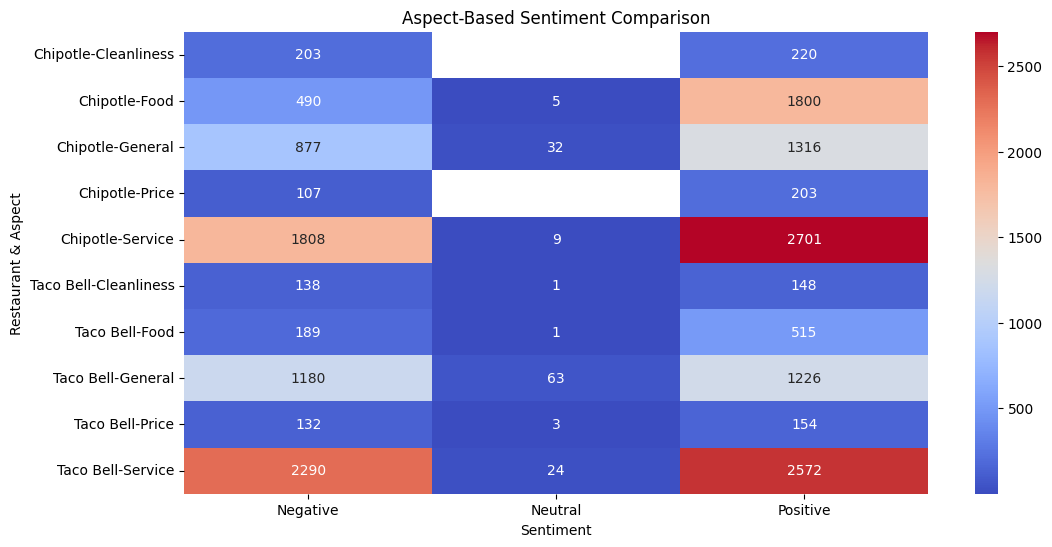

In [ ]:
# 4.3 Aspect-Specific Sentiment Analysis
aspect_sentiment_counts = df.groupby(["name", "aspect", "sentiment"]).size().unstack()
print(aspect_sentiment_counts)


# Heatmap for aspect-based sentiment
plt.figure(figsize=(12, 6))
sns.heatmap(aspect_sentiment_counts, annot=True, cmap="coolwarm", fmt="g")
plt.title("Aspect-Based Sentiment Comparison")
plt.xlabel("Sentiment")
plt.ylabel("Restaurant & Aspect")
plt.show()

##5. Fine-Tuned BERT Sentiment Prediction

In [ ]:
# 5. Using the BERT model for random review sentiment prediction and topic (aspect) analysis

# Function to predict sentiment using the BERT model
def predict_sentiment_bert(text):
    model.eval()  # Set the model to evaluation mode
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_mapping[predicted_class], logits.cpu().numpy()

# Function to extract attention weights from the BERT model (using the last layer)
def get_attention_weights(text):
    model.eval()
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        # Call forward with output_attentions=True to get attention weights
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)

    # outputs.attentions returns a tuple of attention tensors for each layer (shape: [batch_size, num_heads, seq_len, seq_len])
    last_layer_attention = outputs.attentions[-1]  # Get the attention from the last layer
    avg_attention = last_layer_attention.mean(dim=1).squeeze()  # Average over the heads → (seq_len, seq_len)
    token_attention = avg_attention.mean(dim=0)  # Average attention received by each token from all tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    return tokens, token_attention.cpu().numpy()

# Function to display the top tokens with the highest attention weights
def display_top_attention_tokens(tokens, attention_scores, top_n=5):
    # Exclude special tokens ([CLS], [SEP], [PAD])
    token_scores = [(token, score) for token, score in zip(tokens, attention_scores)
                    if token not in ['[CLS]', '[SEP]', '[PAD]']]
    token_scores = sorted(token_scores, key=lambda x: x[1], reverse=True)
    print("Top tokens by attention weight:")
    for token, score in token_scores[:top_n]:
        print(f"{token}: {score:.4f}")

# Sample 5 random reviews from the DataFrame
sample_reviews = df.sample(n=5, random_state=42)

for index, row in sample_reviews.iterrows():
    review_text = row['final_text']
    bert_sentiment, logits = predict_sentiment_bert(review_text)

    print("Review Text:")
    print(review_text)
    print("BERT Model Sentiment Prediction:", bert_sentiment)
    print("Keyword-based Aspect:", row["aspect"])

    # Extract attention weights and display top tokens
    tokens, attention_scores = get_attention_weights(review_text)
    display_top_attention_tokens(tokens, attention_scores, top_n=5)

    print("-" * 80)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Review Text:
be try remember even keep come drive thru 20 minute someone talk sense please literally bad
BERT Model Sentiment Prediction: Negative
Keyword-based Aspect: General
Top tokens by attention weight:
please: 0.1785
bad: 0.1753
sense: 0.0927
literally: 0.0833
remember: 0.0628
--------------------------------------------------------------------------------
Review Text:
order box you like think tht 5 sauce good enough party box tht you need tighten get well worker lady look like be dumb ask   sauce give three pack like toss tht back disappointed
BERT Model Sentiment Prediction: Positive
Keyword-based Aspect: General
Top tokens by attention weight:
well: 0.0667
like: 0.0642
good: 0.0639
like: 0.0636
like: 0.0632
--------------------------------------------------------------------------------
Review Text:
love place almost everything organic locally grow staff superb definitely make feel welcome first visit recognize never show option available small menu be definitely need simple 